## &nbsp; Unsupervised machine learning: Applying K-means clustering to the spotify dataset 

---
#### Import libraries and files 💾

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import plotly.graph_objects as go
import plotly.express as px

from sklearn import set_config
set_config(transform_output="pandas")

In [2]:
# 3_spotify_5000_songs
# URL to download the Google Sheet as a CSV
url = "https://drive.google.com/file/d/1TbIMQEsjJUZrdcY78Dtdl-q-5H7ryBNt/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]

# Create a Pandas DataFrame from the CSV data
spotify_5000_songs = pd.read_csv(path)

First, we create a copy of our original dataframe:

In [3]:
spotify_5000_songs_df = spotify_5000_songs.copy()

Exploring the data:

In [4]:
spotify_5000_songs_df.sample(1)

Unnamed: 0  \
1490        1490   

     name                                                                                                                                                                               \
1490  Waiting for Tonight                           ...                                                                                                                                  

      artist                                            danceability   \
1490  Jennifer Lopez                                            0.694   

      energy     key   loudness   mode   speechiness   acousticness   \
1490      0.941    10     -6.108      0        0.0408        0.00224   

      instrumentalness   liveness   valence   tempo     type   duration_ms   \
1490             0.0826      0.109     0.854   125.014               246507   

      time_signature   id                       \
1490                4  5jOvmh1DYmaiBPETL6HCRY    

                                                   html  
1490  https://open.spotify.com/track/5jOvmh1DYmaiBPE...

In [5]:
# Calculate the average score for each column
average_scores = spotify_5000_songs_df.mean(numeric_only=True)

# Sort the columns by their average scores in descending order
sorted_columns = average_scores.sort_values(ascending=False)
sorted_columns

duration_ms          247911.169245
Unnamed: 0             2617.000000
tempo                   118.721407
key                       5.254441
time_signature            3.902961
energy                    0.653565
mode                      0.646227
danceability              0.509503
valence                   0.443596
acousticness              0.290043
instrumentalness          0.257337
liveness                  0.185354
speechiness               0.083178
loudness                 -9.338098
dtype: float64

In [6]:
# Calculate the minimun score for each column
min_scores = spotify_5000_songs_df.min(numeric_only=True)
sorted_min = min_scores.sort_values(ascending=False)

# Calculate the maximum score for each column
max_scores = spotify_5000_songs_df.max(numeric_only=True)
sorted_max = max_scores.sort_values(ascending=False)

sorted_min, sorted_max

(duration_ms          32760.0
 Unnamed: 0               0.0
 energy                   0.0
 key                      0.0
 mode                     0.0
 danceability             0.0
 liveness                 0.0
 speechiness              0.0
 instrumentalness         0.0
 acousticness             0.0
 tempo                    0.0
 valence                  0.0
 time_signature           0.0
 loudness               -60.0
 dtype: float64,
 duration_ms          3815787.000
 Unnamed: 0              5234.000
 tempo                    213.990
 key                       11.000
 time_signature             5.000
 loudness                   1.342
 energy                     1.000
 mode                       1.000
 acousticness               0.996
 liveness                   0.987
 valence                    0.985
 instrumentalness           0.985
 danceability               0.967
 speechiness                0.918
 dtype: float64)

In [7]:
# Calculate the standard deviation score for each column
std_scores = spotify_5000_songs_df.std(numeric_only=True)
sorted_std = std_scores.sort_values(ascending=False)
sorted_std

duration_ms          135633.023104
Unnamed: 0             1511.358660
tempo                    28.568463
loudness                  6.294850
key                       3.571559
mode                      0.478185
time_signature            0.420324
instrumentalness          0.370686
acousticness              0.355985
energy                    0.288335
valence                   0.277725
danceability              0.218041
liveness                  0.149410
speechiness               0.071193
dtype: float64

---
### 1.&nbsp; Feature selection & data cleaning

- **When to Use**: Use features when you have raw data that needs to be transformed or selected based on their relevance and importance.
- **Purpose**: Features are the measurable properties or characteristics of the data that are used for analysis or modeling.
- **Best Practices**: Conduct feature engineering (creating new features that may be more predictive) or feature selection (choosing the most relevant features) based on domain knowledge and exploratory data analysis.

#### 1.1.&nbsp; Feature selection

In [8]:
print(spotify_5000_songs_df.columns)

Index(['Unnamed: 0',
       'name                                                                                                                                                                             ',
       'artist                                          ', 'danceability ',
       'energy   ', 'key ', 'loudness ', 'mode ', 'speechiness ',
       'acousticness ', 'instrumentalness ', 'liveness ', 'valence ',
       'tempo   ', 'type ', 'duration_ms ', 'time_signature ',
       'id                     ', 'html'],
      dtype='object')


In [9]:
# The columns need to be cleaned
spotify_5000_songs_df.columns = spotify_5000_songs_df.columns.str.strip()

In [10]:
print(spotify_5000_songs_df.columns)

Index(['Unnamed: 0', 'name', 'artist', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'duration_ms', 'time_signature',
       'id', 'html'],
      dtype='object')


In [11]:
# Setting the index to artist + song
spotify_5000_songs_df.loc[:, 'combined_index'] = spotify_5000_songs_df.loc[:, 'artist'] + ' - ' + spotify_5000_songs_df.loc[:, 'name']
spotify_5000_songs_df = spotify_5000_songs_df.set_index("combined_index")

In [12]:
spotify_5000_songs_df_ml = (spotify_5000_songs_df
                       .drop(columns= 
                             ['Unnamed: 0', 'name', 'artist', 'type', 'id', 'html']
                             ))

In [13]:
spotify_5000_songs_df_ml.sample(3)

danceability  energy  key  \
combined_index                                                                  
Entombed                                       ...        0.1240  0.9610    7   
Ex Confusion                                   ...        0.1480  0.0329    8   
GAS                                            ...        0.0748  0.0410    5   

                                                    loudness  mode  \
combined_index                                                       
Entombed                                       ...    -6.607     1   
Ex Confusion                                   ...   -29.836     0   
GAS                                            ...   -18.582     1   

                                                    speechiness  acousticness  \
combined_index                                                                  
Entombed                                       ...       0.1110      0.000002   
Ex Confusion                                   ...       0.0418      0.988000   
GAS                                            ...       0.0405      0.924000   

                                                    instrumentalness  \
combined_index                                                         
Entombed                                       ...             0.850   
Ex Confusion                                   ...             0.973   
GAS                                            ...             0.948   

                                                    liveness  valence  \
combined_index                                                          
Entombed                                       ...    0.0678   0.1940   
Ex Confusion                                   ...    0.1100   0.0567   
GAS                                            ...    0.0890   0.4260   

                                                      tempo  duration_ms  \
combined_index                                                             
Entombed                                       ...  172.986       268200   
Ex Confusion                                   ...  138.405       328493   
GAS                                            ...   82.531       311560   

                                                    time_signature  
combined_index                                                      
Entombed                                       ...               4  
Ex Confusion                                   ...               4  
GAS                                            ...               3

#### 1.2.&nbsp; Data cleaning

In [14]:
spotify_5000_songs_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5235 entries, Gilberto Gil                                     - Se Eu Quiser Falar Com Deus                                                                                                                                                       to Maurice Ravel                                    - Ravel: Boléro, M. 81                                                                                                                                                           
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5235 non-null   float64
 1   energy            5235 non-null   float64
 2   key               5235 non-null   int64  
 3   loudness          5235 non-null   float64
 4   mode              5235 non-null   int64  
 5   speechiness       5235 non-null   float64
 6   acousticness      5235 non-null   float64
 7   instrumentalness  523

##### 1.2.1.&nbsp; Duplicates
- We can check for duplicates using the pandas ``.duplicated()`` method.
- We can then delete these rows, if we wish, using ``.drop_duplicates()``

In [15]:
spotify_5000_songs_df_ml.duplicated().sum()

np.int64(75)

In [16]:
spotify_5000_songs_df_ml = spotify_5000_songs_df_ml.drop_duplicates()

In [17]:
spotify_5000_songs_df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5160 entries, Gilberto Gil                                     - Se Eu Quiser Falar Com Deus                                                                                                                                                       to Maurice Ravel                                    - Ravel: Boléro, M. 81                                                                                                                                                           
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5160 non-null   float64
 1   energy            5160 non-null   float64
 2   key               5160 non-null   int64  
 3   loudness          5160 non-null   float64
 4   mode              5160 non-null   int64  
 5   speechiness       5160 non-null   float64
 6   acousticness      5160 non-null   float64
 7   instrumentalness  516

#### 1.3.&nbsp; Data understanding and outliers

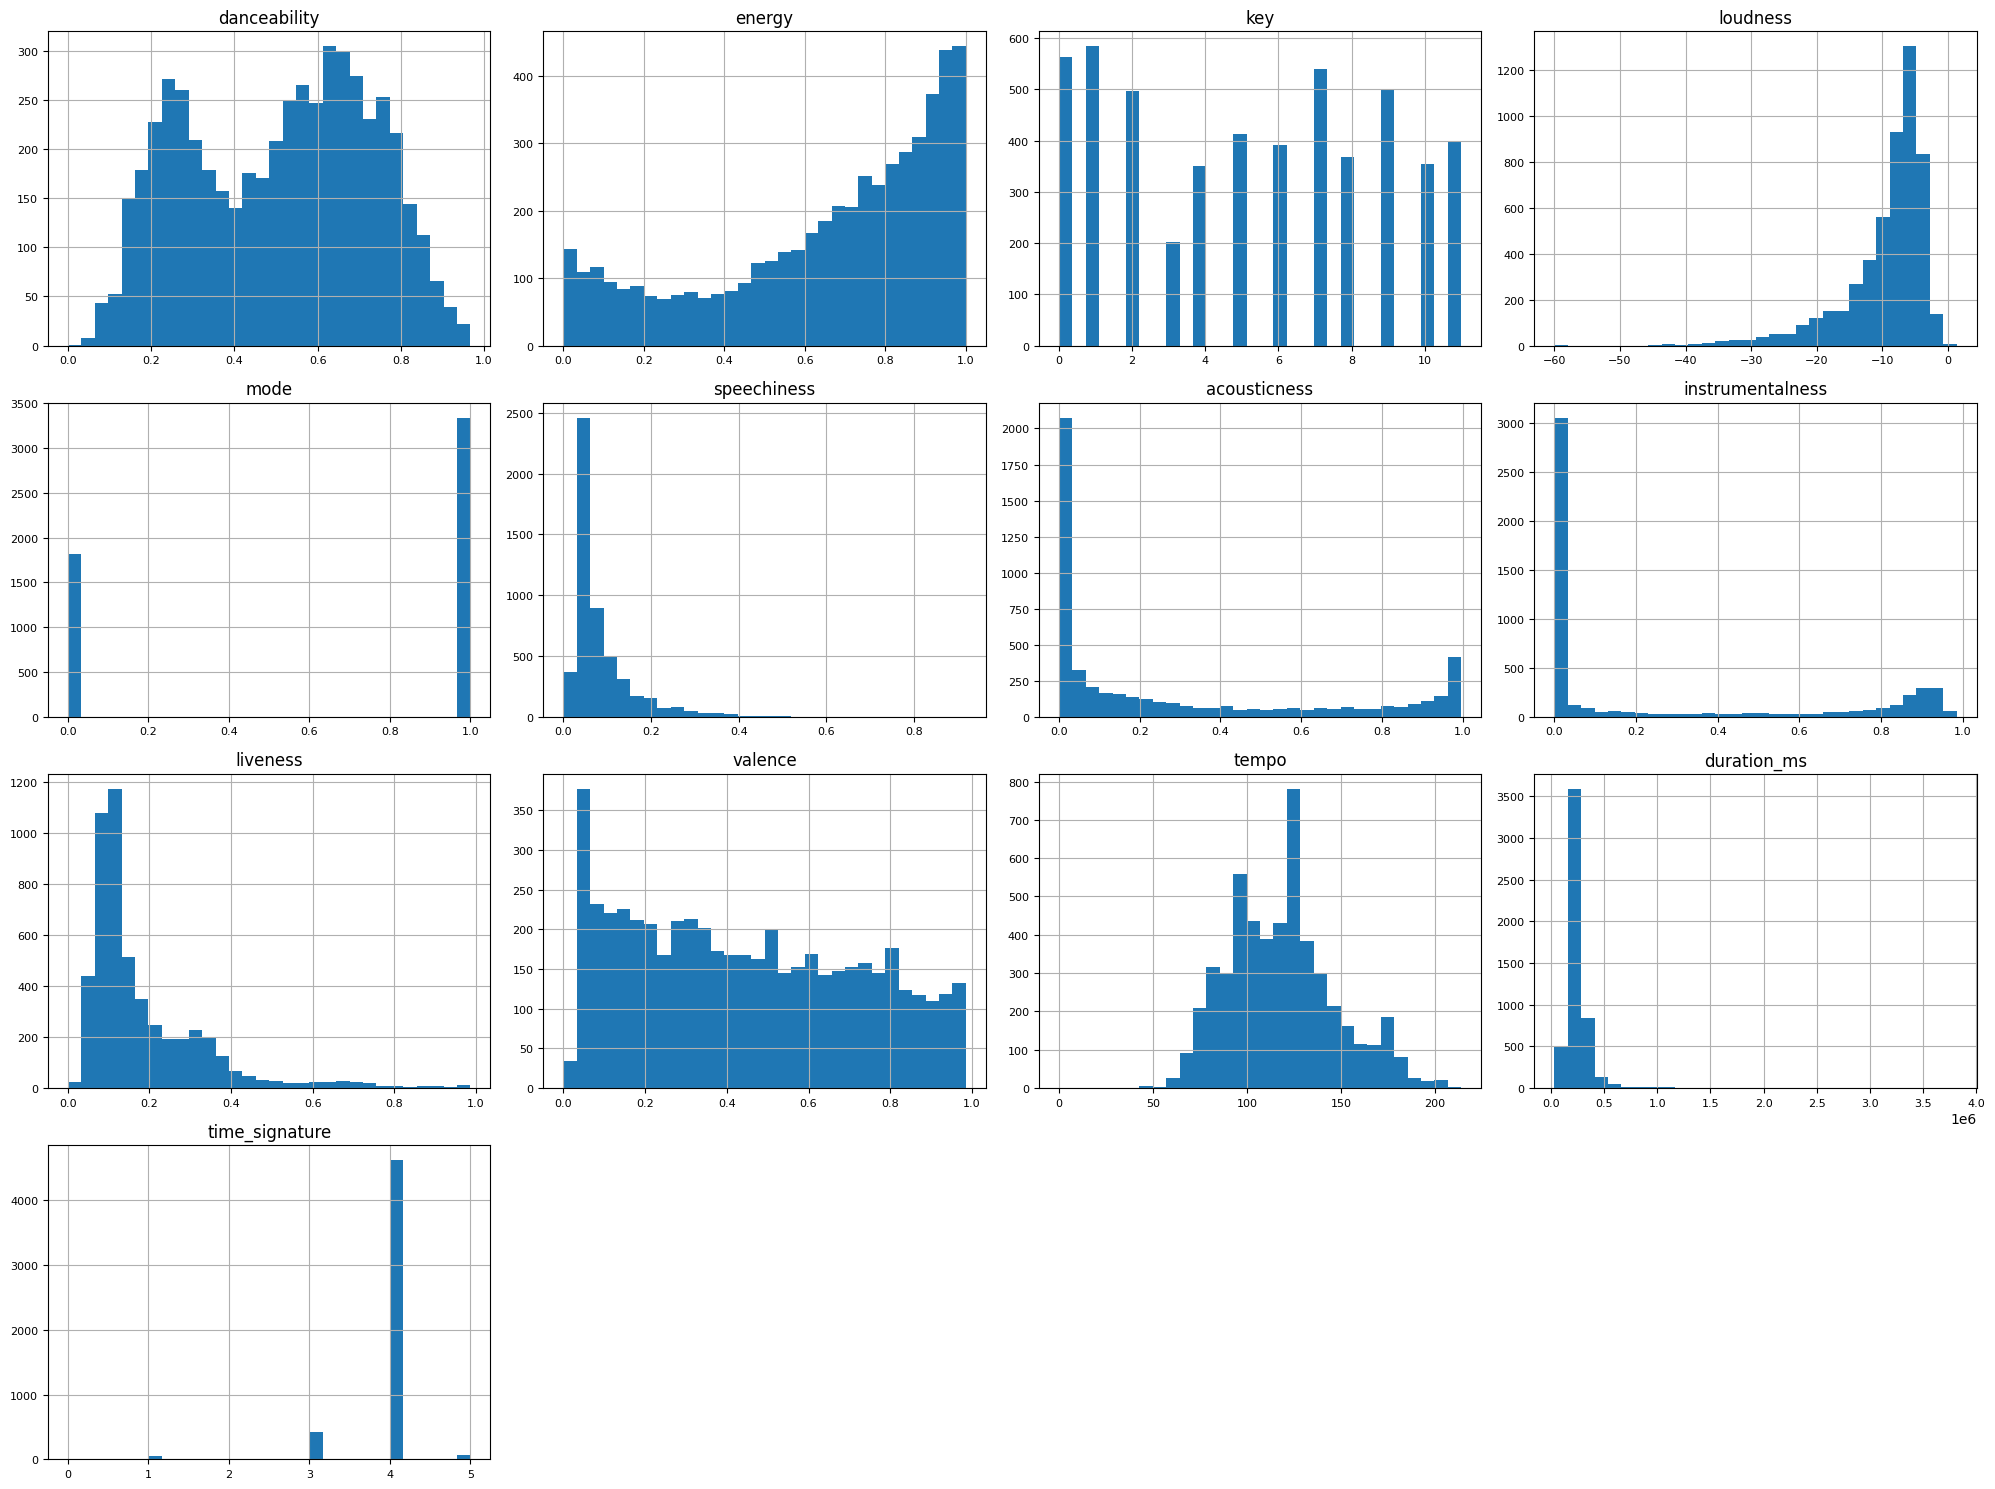

In [18]:
spotify_5000_songs_df_ml.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

In [19]:
# Set the quantile value
x = 0.001
loudness_cutoff = spotify_5000_songs_df_ml['loudness'].quantile(x)
loudness_outliers = spotify_5000_songs_df_ml[spotify_5000_songs_df_ml['loudness'] <= loudness_cutoff]
loudness_outliers.loc[:, 'loudness']

combined_index
Taylor Swift                                     - Shake It Off                                                                                                                                                                        -60.000
Ludwig van Beethoven                             - I. Adagio sostenuto                                                                                                                                                                 -43.851
Frédéric Chopin                                  - Mazurka in A Minor, Op. 17 No. 4                                                                                                                                                    -42.117
Pauline Oliveros                                 - Suiren                                                                                                                                                                              -44.406
Charles Ives                 

Let's remove the song ``Taylor Swift-Shake It Off``, as it is an outlier.

In [20]:
spotify_5000_songs_df_ml = spotify_5000_songs_df_ml[spotify_5000_songs_df_ml['loudness'] > -55]

In [21]:
# Set the quantile value
x = 0.001

# 2. For speechiness: Cut the right part (highest 5%)
speechiness_cutoff = spotify_5000_songs_df_ml['speechiness'].quantile(1 - x)
speechiness_outliers = spotify_5000_songs_df_ml[spotify_5000_songs_df_ml['speechiness'] >= speechiness_cutoff]

speechiness_outliers.loc[:, 'speechiness'].sort_values(ascending=False)

combined_index
Duckwrth                                         - I'M DEAD                                                                                                                                                                             0.918
MiMS                                             - This Is Why I'm Hot                                                                                                                                                                  0.576
Boys Noize                                       - Got It                                                                                                                                                                               0.518
Tego Calderon                                    - Pegaito a la Pared (feat. Plan B) - Remix                                                                                                                                            0.516
Missy Elliott                    

In [22]:
second_max_speechiness = spotify_5000_songs_df_ml['speechiness'].nlargest(2).iloc[-1]
# Replace the current maximum 'speechiness' with the second maximum value
spotify_5000_songs_df_ml.loc[spotify_5000_songs_df_ml['speechiness'].idxmax(), 'speechiness'] = second_max_speechiness

In [23]:
spotify_5000_songs_df_ml['speechiness'].sort_values(ascending=False).head(3)

combined_index
Duckwrth                                         - I'M DEAD                                                                                                                                                                             0.576
MiMS                                             - This Is Why I'm Hot                                                                                                                                                                  0.576
Boys Noize                                       - Got It                                                                                                                                                                               0.518
Name: speechiness, dtype: float64

In [24]:
# Set the quantile value
x = 0.001

# 3. For duration_ms: Cut the right part (highest 5%)
duration_cutoff = spotify_5000_songs_df_ml['duration_ms'].quantile(1 - x)
duration_outliers = spotify_5000_songs_df_ml[spotify_5000_songs_df_ml['duration_ms'] >= duration_cutoff]
duration_outliers['minutes'] = (duration_outliers['duration_ms'] / 60000)
duration_outliers.loc[:, 'minutes'].sort_values(ascending=False)

C:\Users\Eli\AppData\Local\Temp\ipykernel_10400\3013218863.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duration_outliers['minutes'] = (duration_outliers['duration_ms'] / 60000)


combined_index
William Basinski                                 - dlp 1.1                                                                                                                                                                              63.596450
Allan Pettersson                                 - Symphony No. 6                                                                                                                                                                       59.844883
Polish National Radio Symphony Orchestra         - Symphony No. 3                                                                                                                                                                       31.561117
Laraaji                                          - Essence                                                                                                                                                                              29.896000
Richard Strauss  

In [25]:
spotify_5000_songs_df_ml.corr().style.background_gradient(cmap='coolwarm')

Features ``key`` and ``time_signature`` are essential for music theory, but don't work for playlist clustering. For example, two songs in the same key can have completely different tempos, genres, and energies. Therefore, we remove them.

In [26]:
# let's remove key and time_signature
spotify_5000_songs_df_ml = spotify_5000_songs_df_ml.drop(columns=['key', 'time_signature'])

---
### 2.&nbsp; Scaling data 🎚️

There are two main reasons why it is important to scale data for unsupervised learning:

- To ensure that all features have equal importance. If some features are on a much larger scale than others, then those features will dominate the algorithm and the other features will have little to no impact. Scaling the data ensures that all features are treated equally.
- To improve the convergence of the algorithm. Many unsupervised learning algorithms are iterative, meaning that they repeatedly update their parameters until they converge to a solution. Scaling the data can help the algorithm to converge more quickly and efficiently.

- **When to Use**: Use scaling when your dataset contains features with different units and scales (e.g., age in years, income in dollars).
- **Purpose**: Scaling transforms features to a similar range or distribution, which is essential for many algorithms, particularly those that rely on distance measures (e.g., K-means, KNN).
- **Best Practices**: Use Standardization (z-score normalization) to center features around zero or Min-Max scaling to transform features into a [0, 1] range. Apply scaling before fitting models, especially for K-means.

In [27]:
spotify_5000_songs_scaling = spotify_5000_songs_df_ml.copy()

In [28]:
spotify_5000_songs_scaling.describe()

danceability       energy     loudness         mode  speechiness  \
count   5159.000000  5159.000000  5159.000000  5159.000000  5159.000000   
mean       0.507521     0.653381    -9.371423     0.647606     0.083089   
std        0.218115     0.289428     6.278944     0.477762     0.070361   
min        0.059600     0.000020   -44.406000     0.000000     0.022600   
25%        0.306000     0.475500   -11.382000     0.000000     0.038900   
50%        0.536000     0.738000    -7.362000     1.000000     0.055700   
75%        0.686500     0.895000    -5.300000     1.000000     0.098800   
max        0.967000     1.000000     1.342000     1.000000     0.576000   

       acousticness  instrumentalness     liveness      valence        tempo  \
count   5159.000000       5159.000000  5159.000000  5159.000000  5159.000000   
mean       0.291504          0.260764     0.185413     0.442243   118.685624   
std        0.356946          0.371997     0.149283     0.277990    28.559589   
min        0.000000          0.000000     0.010900     0.019600    34.856000   
25%        0.002270          0.000001     0.092500     0.195000    96.083500   
50%        0.096200          0.002240     0.125000     0.414000   119.012000   
75%        0.570500          0.658000     0.237000     0.676000   134.054000   
max        0.996000          0.985000     0.987000     0.985000   213.990000   

        duration_ms  
count  5.159000e+03  
mean   2.484237e+05  
std    1.364827e+05  
min    3.276000e+04  
25%    1.898290e+05  
50%    2.251330e+05  
75%    2.721330e+05  
max    3.815787e+06

When we scale with SKLearn we get the choice to use a variety of scalers. Scalers do not change the distribution of the data, they change the range of the data.

> **Remember:** Range = Max - Min

#### 2.1.&nbsp; Min and Max Scaling
All columns get scaled between 0 and 1.
<br>
<br>
\begin{align}
newValue = \frac{oldValue - min(column)}{max(column) - min(column)}
    \end{align}
<br>
Let's apply Min Max scaling to the whole DataFrame:

In [29]:
# Create a MinMaxScaler object
scaler_min_max = MinMaxScaler().set_output(transform="pandas") # If you want to explore set_output further https://blog.scikit-learn.org/technical/pandas-dataframe-output-for-sklearn-transformer/

# Scale the spotify_5000_songs_scaling DataFrame
spotify_5000_songs_minmax = scaler_min_max.fit_transform(spotify_5000_songs_scaling)

In [30]:
spotify_5000_songs_minmax.sample(3)

danceability    energy  \
combined_index                                                               
Malevolent Creation                            ...      0.307913  0.991000   
Yaga Y Mackie                                  ...      0.882081  0.698994   
Seu Jorge                                      ...      0.685916  0.948999   

                                                    loudness  mode  \
combined_index                                                       
Malevolent Creation                            ...  0.853065   1.0   
Yaga Y Mackie                                  ...  0.830441   0.0   
Seu Jorge                                      ...  0.852606   1.0   

                                                    speechiness  acousticness  \
combined_index                                                                  
Malevolent Creation                            ...     0.119986      0.000211   
Yaga Y Mackie                                  ...     0.135164      0.083032   
Seu Jorge                                      ...     0.035237      0.565261   

                                                    instrumentalness  \
combined_index                                                         
Malevolent Creation                            ...          0.082640   
Yaga Y Mackie                                  ...          0.002000   
Seu Jorge                                      ...          0.004091   

                                                    liveness   valence  \
combined_index                                                           
Malevolent Creation                            ...  0.092306  0.057593   
Yaga Y Mackie                                  ...  0.255199  0.881914   
Seu Jorge                                      ...  0.334085  0.974104   

                                                       tempo  duration_ms  
combined_index                                                             
Malevolent Creation                            ...  0.463564     0.022310  
Yaga Y Mackie                                  ...  0.330122     0.071578  
Seu Jorge                                      ...  0.374692     0.059589

Let's have a look at the affect MinMax scaling had on the heatmap

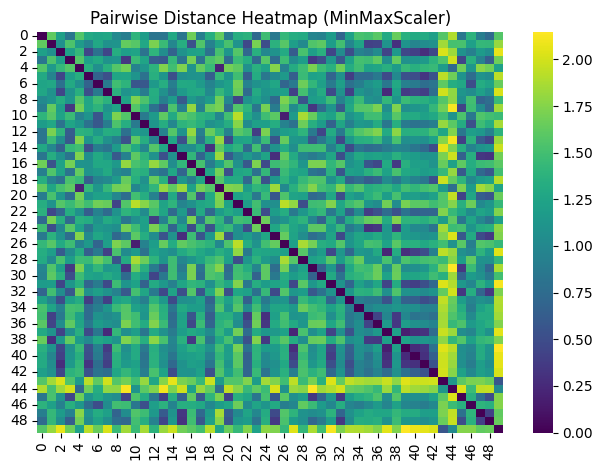

In [31]:
df_minmax_sample = spotify_5000_songs_minmax.sample(n=50, random_state=42)

# Compute pairwise distances
dist_minmax = pairwise_distances(df_minmax_sample)

# Plot the heatmaps side by side
#fig, axes = plt.subplots(2, figsize=(20, 8))

# MinMaxScaler heatmap
sns.heatmap(dist_minmax, cmap='viridis').set_title("Pairwise Distance Heatmap (MinMaxScaler)")

# Display the plots
plt.tight_layout()
plt.show()

We choose **Minmax scaler** method for our next steps.

In [32]:
spotify_5000_songs_minmax_scaled = spotify_5000_songs_minmax.copy()

---
### 3.&nbsp; PCA ⚙️

PCA creates as many principal components as the original DataFrame has columns. We then need to decide how many of these components to keep. Before we do that, let's look at how PCA transforms our DataFrame.

- **When to Use**: Use PCA when you have high-dimensional data and want to reduce the number of features while preserving variance.
- **Purpose**: PCA helps in visualizing the data, eliminating noise, and improving the efficiency of other algorithms by reducing dimensionality.
- **Best Practices**: Apply PCA after scaling your data. Decide on the number of principal components to keep based on the explained variance ratio (e.g., keeping enough components to explain 95% of variance).

In [33]:
spotify_5000_PCA = spotify_5000_songs_minmax_scaled.copy()

In [34]:
# Initialise the PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(spotify_5000_PCA)

# Transform spotify_5000_PCA based on the fit calculations
pca_basic_df = pca.transform(spotify_5000_PCA)

pca_basic_df.sample(3)

pca0      pca1  \
combined_index                                                           
Dayvi                                          ... -0.243228  0.392821   
Gorefest                                       ... -0.271877  0.413077   
Mabel                                          ... -0.291925 -0.590655   

                                                        pca2      pca3  \
combined_index                                                           
Dayvi                                          ... -0.286200  0.319213   
Gorefest                                       ... -0.298208 -0.354643   
Mabel                                          ...  0.355343 -0.006192   

                                                        pca4      pca5  \
combined_index                                                           
Dayvi                                          ... -0.042351  0.087755   
Gorefest                                       ... -0.060025 -0.167452   
Mabel                                          ...  0.432910 -0.221524   

                                                        pca6      pca7  \
combined_index                                                           
Dayvi                                          ...  0.187668  0.023983   
Gorefest                                       ...  0.135926  0.219899   
Mabel                                          ...  0.080099  0.357332   

                                                        pca8      pca9  \
combined_index                                                           
Dayvi                                          ... -0.145514 -0.017999   
Gorefest                                       ...  0.001921 -0.084060   
Mabel                                          ... -0.132674  0.004616   

                                                       pca10  
combined_index                                                
Dayvi                                          ... -0.004490  
Gorefest                                       ...  0.030518  
Mabel                                          ... -0.003556

> You may notice that we have the same amount of columns as before but we have lost the column names. This is because the columns are now principal components and not the original features (danceability, speechiness, etc...). Principal components are an abstraction of the original features, capturing the most significant patterns and trends within the data. They are like new axes along which the data is spread out, representing directions of maximum variance. The first principal component explains the largest amount of variance, followed by the second, and so on.

#### 3.1.&nbsp; Identifying the most informative principal components

Principal component analysis (PCA) assumes that variance is information. This means that PCA believes that the directions in which the data varies the most are the most important.

When we fit PCA to our data, it calculates all of the principal components. We can see how much variance each principal component explains using the `explained_variance_ratio_` attribute.
> The principal components are ranked in order of decreasing variance, with the first principal component explaining the most variance in the data

In [35]:
# Get the variance explained by each principal component
explained_variance_array = pca.explained_variance_ratio_

explained_variance_array

array([0.31610881, 0.28136186, 0.20671355, 0.06895247, 0.03313823,
       0.02900595, 0.02375677, 0.01931654, 0.01569838, 0.00447236,
       0.00147509])

To determine how many principal components to keep, we can use one of two methods:

- **Elbow method**: This is a more manual approach where we plot the explained variance of each principal component against its index. The elbow point is the point at which the explained variance starts to drop off significantly. This is the point at which it is no longer worth retaining any more principal components, as they are not explaining much additional variance.
- **Cumulative explained variance**: This is a more automated approach where SKLearn calculates how many principal components contain a given amount of variance, such as 95%.

##### 3.1.1.&nbsp; Elbow method
The elbow method works by plotting the variance of each principal component against its index.

In [36]:
pd.DataFrame(explained_variance_array, columns=["Variance explained"])

Variance explained
0             0.316109
1             0.281362
2             0.206714
3             0.068952
4             0.033138
5             0.029006
6             0.023757
7             0.019317
8             0.015698
9             0.004472
10            0.001475

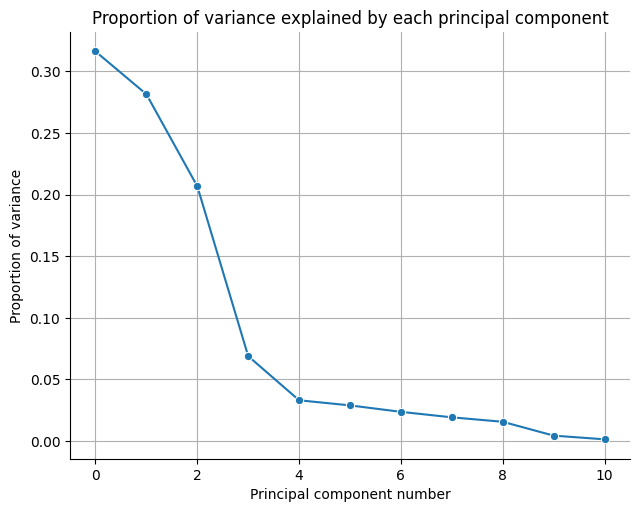

In [37]:
# Create a Pandas DataFrame from the variance explained array
explained_variance_array_df = pd.DataFrame(explained_variance_array, columns=["Variance explained"])

(
  # Create a line chart with sns.relplot
  sns.relplot(
      kind = 'line',
      data = explained_variance_array_df,
      x = explained_variance_array_df.index,
      y = "Variance explained",
      marker = 'o',
      aspect = 1.3)
  # Set the title of the plot
  .set(title = "Proportion of variance explained by each principal component")
  # Set the axis labels
  .set_axis_labels("Principal component number", "Proportion of variance")
);

plt.grid(True)
plt.show()

We are looking for a point where the decrease in variance levels off. This point, known as the elbow point, marks the point at which the explained variance starts to reduce significantly.

In [38]:
# Set the variable elbow to where you believe the elbow is
elbow = 8
n_components = elbow + 1
n_components

9

##### 3.1.2.&nbsp; Cumulative explained variance
Cumulative explained variance (CEV) is calculated by summing the explained variance of each principal component. The CEV plot shows how much variance is explained by each principal component, as well as the cumulative variance explained by all principal components up to that point.

In [39]:
cumulative_sum_of_variance = np.cumsum(explained_variance_array)

cumulative_sum_of_variance

array([0.31610881, 0.59747067, 0.80418422, 0.87313668, 0.90627491,
       0.93528086, 0.95903763, 0.97835417, 0.99405255, 0.99852491,
       1.        ])

We will set a cumulative variance threshold in the PCA constructor. This threshold tells scikit-learn how many principal components to retain. For example, 0.95 tells scikit-learn that we want to retain as many principle components as contain 95% or more of the variance.

In [40]:
# Create a PCA object
pca_variance = PCA(n_components = 0.95)

Let's visualise this threshold

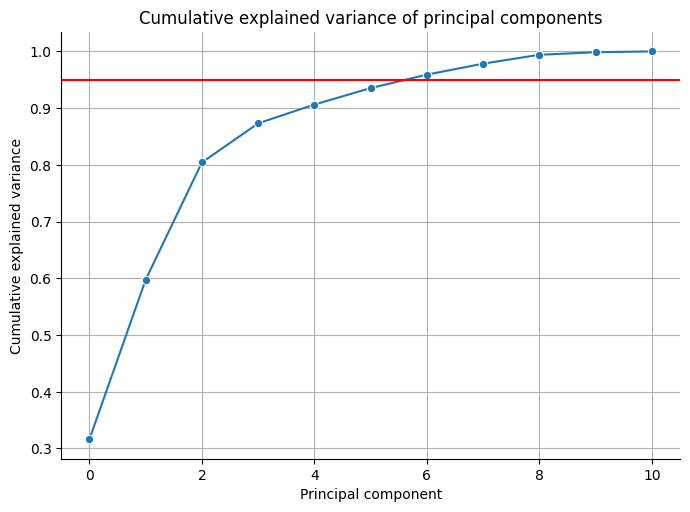

In [41]:
(
  # Create a cumulative explained variance plot
  sns.relplot(
      kind = "line",  # Create a line plot
      x = range(len(explained_variance_array)),  # Set the x-axis to be the principal component index
      y = cumulative_sum_of_variance,  # Set the y-axis to be the cumulative explained variance
      marker = "o",  # Use a circle marker for the data points
      aspect = 1.4,  # Set the aspect ratio of the plot to be 1.4
  )
  # Set the title of the plot
  .set(title="Cumulative explained variance of principal components")
  # Set the axis labels
  .set_axis_labels("Principal component", "Cumulative explained variance")
);

# Add a horizontal red line at 0.95 on the y axis
plt.axhline(y = 0.95,
            color = 'red');

plt.grid(True)
plt.show()

Find out how many components make up 95% of the variance

In [42]:
# Calculate the cumulative sum
cumulative_sum = np.cumsum(explained_variance_array)

# Find the index where the cumulative sum reaches 0.95
index = np.searchsorted(cumulative_sum, 0.95)

# Print the number of components required to reach 0.95 variance
print(index + 1)

7


In ``Elbow method``, we defined the number of components to be 9, but the ``Cumulative Explained Variance`` is a more accurate method  and defined the number of components to be 7. Therefore, we choose it to be 7, which tells scikit-learn that we want to retain as many principle components as contain 95% of the variance.

Let's apply this to our scaled data

In [43]:
# Fit the PCA object to the scaled features dataframe and transform it
pca_variance_df = pca_variance.fit_transform(pca_basic_df)

# The dataframe now contains the principal components of the scaled features dataframe
pca_variance_df

pca0      pca1  \
combined_index                                                           
Gilberto Gil                                   ...  0.096136 -0.679796   
Antônio Carlos Jobim                           ... -0.135237  0.388148   
Martinho Da Vila                               ... -0.281878  0.414121   
Chico César                                    ...  0.446674  0.272223   
Kurt Elling                                    ...  0.511252  0.261093   
...                                                      ...       ...   
Pyotr Ilyich Tchaikovsky                       ...  1.192235  0.113563   
Tristan Murail                                 ...  1.001833  0.160587   
Arnold Schoenberg                              ...  1.523928  0.045149   
Antonín Dvořák                                 ...  1.138227  0.133349   
Maurice Ravel                                  ...  0.905786  0.173551   

                                                        pca2      pca3  \
combined_index                                                           
Gilberto Gil                                   ...  0.516554 -0.292388   
Antônio Carlos Jobim                           ...  0.396328  0.100987   
Martinho Da Vila                               ...  0.467163  0.277768   
Chico César                                    ...  0.828098 -0.078890   
Kurt Elling                                    ...  0.763649 -0.165154   
...                                                      ...       ...   
Pyotr Ilyich Tchaikovsky                       ...  0.129515 -0.111270   
Tristan Murail                                 ...  0.218386 -0.322311   
Arnold Schoenberg                              ...  0.017656 -0.014039   
Antonín Dvořák                                 ...  0.231145 -0.277182   
Maurice Ravel                                  ...  0.316651 -0.082893   

                                                        pca4      pca5  \
combined_index                                                           
Gilberto Gil                                   ...  0.247788  0.637553   
Antônio Carlos Jobim                           ... -0.115936 -0.135223   
Martinho Da Vila                               ... -0.095818  0.127416   
Chico César                                    ...  0.016145  0.173742   
Kurt Elling                                    ... -0.029135 -0.092928   
...                                                      ...       ...   
Pyotr Ilyich Tchaikovsky                       ... -0.096201 -0.012065   
Tristan Murail                                 ... -0.112914 -0.021217   
Arnold Schoenberg                              ... -0.133654  0.018430   
Antonín Dvořák                                 ... -0.140925  0.051780   
Maurice Ravel                                  ... -0.155687  0.204774   

                                                        pca6  
combined_index                                                
Gilberto Gil                                   ...  0.426917  
Antônio Carlos Jobim                           ...  0.077549  
Martinho Da Vila                               ...  0.000084  
Chico César                                    ...  0.186341  
Kurt Elling                                    ...  0.098080  
...                                                      ...  
Pyotr Ilyich Tchaikovsky                       ... -0.071372  
Tristan Murail                                 ... -0.123358  
Arnold Schoenberg                              ... -0.169706  
Antonín Dvořák                                 ... -0.174716  
Maurice Ravel                                  ... -0.035364  

[5159 rows x 7 columns]

In this example, we were able to successfully reduce an 12-dimensional dataset to a more manageable 9-dimensional representation. This significant reduction in dimensionality not only helps to minimize noise but also substantially improves training times.

---
### 4.&nbsp; Estimate the number of clusters (k) with PCA 🔢

#### 4.1.&nbsp; Inertia and the elbow method

In clustering, inertia is a measure of how well data points fit into their assigned clusters. Lower inertia indicates a better fit. However, minimising inertia alone can lead to meaningless clusters, with each data point in its own cluster.

The elbow method is a visual aid for identifying the optimal number of clusters. It plots inertia values for different cluster numbers, revealing an "elbow" where the inertia reduction begins to plateau. This plateau indicates that reducing inertia further has little impact on cluster quality.

To find the inertia score for our clusters, we can use the [KMeans attribute ](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)`.inertia_`.

We will cluster our data multiple times, starting with 1 cluster and increasing the number of clusters by 1 each time until we reach `max_k`. We will store the inertia score for each clustering in a list.

Once we've calculated the inertia scores for all values of k, we'll plot them on a line chart. We'll then look for the "elbow" in the line chart. The elbow is the point where the inertia score starts to plateau, indicating that adding more clusters is not significantly improving the quality of the clustering.

In [44]:
spotify_5000_PCA_K = pca_basic_df.copy()

In [45]:
# Decide on a random_state to use
seed = 789

# Set the maximum number of clusters to try
max_k = 100

# Create an empty list to store the inertia scores
inertia_list = []

# Iterate over the range of cluster numbers
for i in range(1, max_k + 1):

    # Create a KMeans object with the specified number of clusters
    myKMeans = KMeans(n_clusters = i,
                      n_init = "auto",
                      random_state = seed)

    # Fit the KMeans model to the scaled data
    myKMeans.fit(spotify_5000_PCA_K)

    # Append the inertia score to the list
    inertia_list.append(myKMeans.inertia_)

In [46]:
inertia_list

[4172.322206064233,
 3170.3460387464406,
 2202.161121727778,
 2041.1788507269105,
 1570.9560285301902,
 1372.98017583132,
 1263.1151519583016,
 1135.826148846009,
 1096.5312485944933,
 1028.6249524800246,
 891.6210203298991,
 845.2553281900261,
 828.9725460127988,
 814.2018785769309,
 793.3821523852221,
 775.2352546042331,
 757.5155668825514,
 742.0960824163893,
 724.637900604867,
 714.2708393725985,
 706.8267632747081,
 680.3250675070439,
 670.286380725043,
 663.1658607487599,
 656.3705255416027,
 645.1629127886081,
 630.4333034995304,
 620.0276806616986,
 615.2904983022997,
 609.0369050354055,
 603.8544723724278,
 598.8901660637327,
 593.3891130879854,
 586.0286970413785,
 576.9394755407111,
 571.0942840590517,
 568.1753051045891,
 560.2268349609261,
 552.9148831845873,
 545.7728500430977,
 539.4593639091834,
 535.7778843304045,
 531.2862098793253,
 528.422402856536,
 524.9234738483455,
 519.776446615704,
 515.3401856407326,
 513.487173462209,
 510.57112595622596,
 506.10393990357613

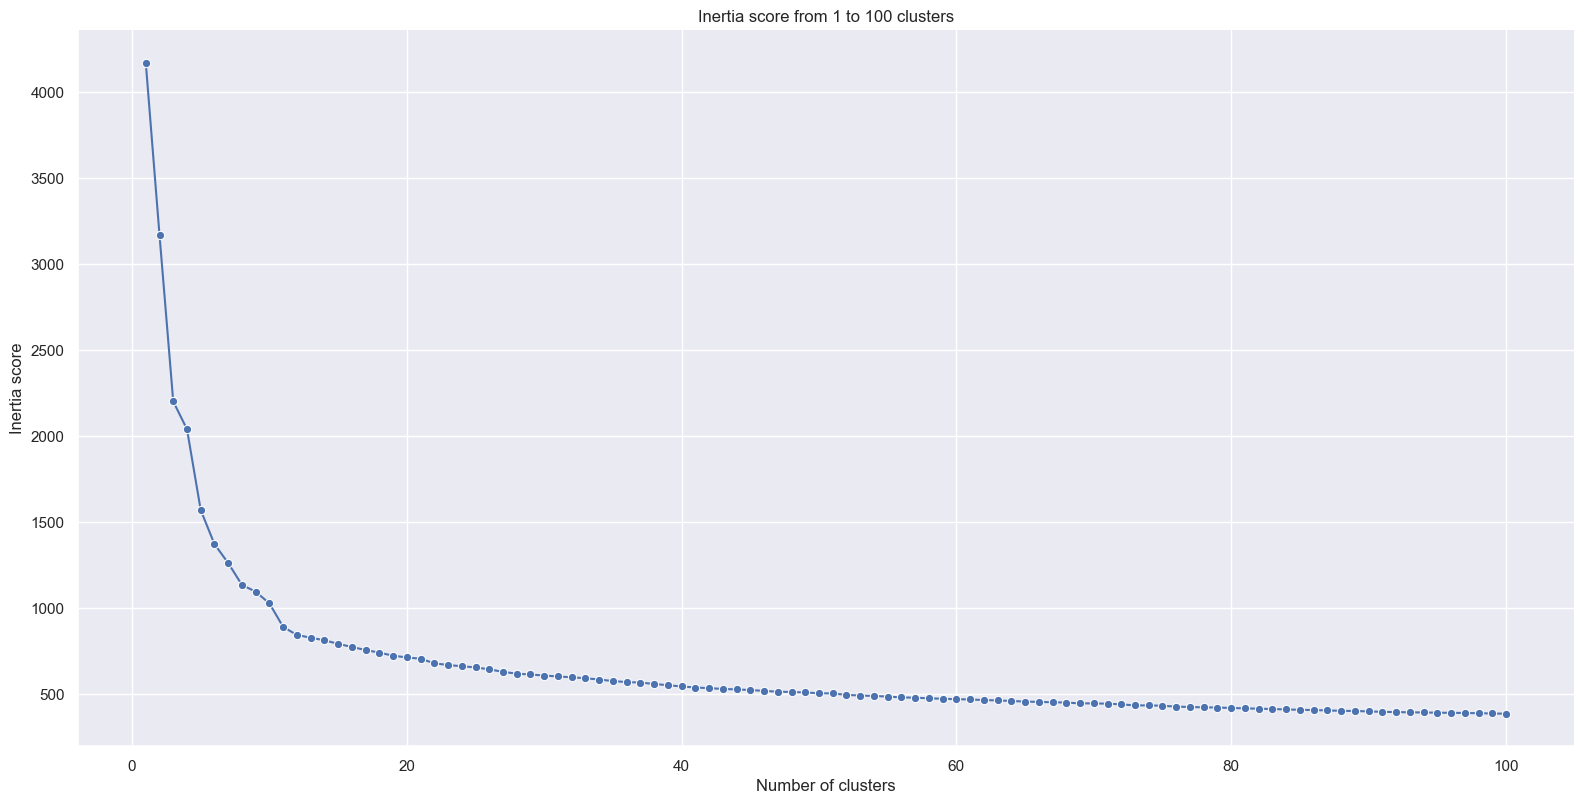

In [47]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

(
# Create a line plot of the inertia scores
sns.relplot(y = inertia_list,
            x = range(1, max_k + 1),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
# Set the title of the plot
.set(title=f"Inertia score from 1 to {max_k} clusters")
# Set the axis labels
.set_axis_labels("Number of clusters", "Inertia score")
);

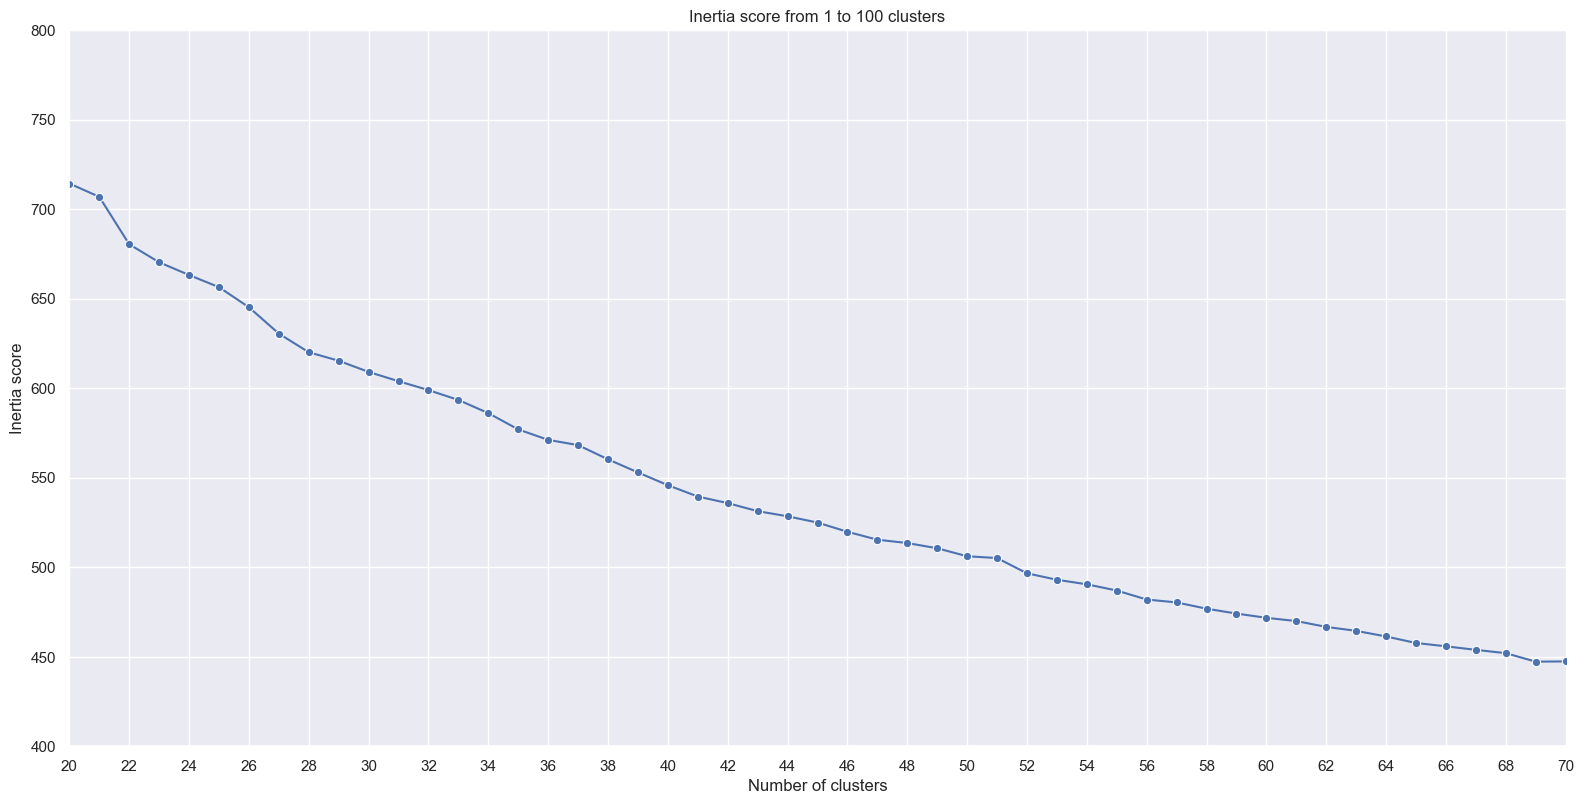

In [48]:
# Set the Seaborn theme to darkgrid
sns.set_theme(style='darkgrid')

# Create a line plot of the inertia scores
sns.relplot(y = inertia_list,
            x = range(1, max_k + 1),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2).set(# Set the title of the plot
                title=f"Inertia score from 1 to {max_k} clusters"
                ).set_axis_labels(# Set the axis labels
                    "Number of clusters", "Inertia score"
                    )

# Set x-axis limits to show only the range from 20 to 70
plt.xlim(20, 70)

# Set y-axis limits
plt.ylim(400, 800)

# Set custom x-ticks with an interval of 2
plt.xticks(range(20, 71, 2))  # x-values from 20 to 70 with an interval of 2

# Show the plot
plt.show()

Where the elbow lies is not always clear - it's up to you to decide, you're the data scientist. If there are multiple points where you believe the elbow could be, use your knowledge of the business case to inform your decision. How many data points do you have? How many would be in a cluster if you chose this number of clusters? What is the point of making these clusters? Is there a logical number of clusters, where if you make more clusters they just become too small for your business case?
> The elbow method is a heuristic, meaning that it is not guaranteed to find the optimal number of clusters in all cases.

In our case, we have been asked to create playlists and we have not been given a hard limit for the number of playlists, but we have been asked to keep the size of all the playlists between 50 and 250 songs. If we have a dataset with roughly 5000 songs, that means that we should explore having between 20 and 100 clusters.

#### 4.2.&nbsp; The silhouette score
The silhouette score is another metric for evaluating the quality of clustering results. It measures how well each data point is assigned to its cluster, taking into account the distance to other clusters. The silhouette score ranges from -1 to 1, with higher scores indicating better clustering.

The silhouette score can be used to identify the optimal number of clusters by clustering the data with different numbers of clusters and selecting the number of clusters that has the highest silhouette score.

To calculate the silhouette score we'll use the [SKLearn function ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)`silhouette_score`.

In [49]:
# Set the maximum number of clusters to try
max_k = 100

# Create an empty list to store the silhouette scores
sil_scores = []


for j in range(2, max_k):

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters = j,
                    n_init = "auto",
                    random_state = seed)

    # Fit the KMeans model to the scaled data
    kmeans.fit(spotify_5000_PCA_K)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score
    score = silhouette_score(spotify_5000_PCA_K, labels)

    # Append the silhouette score to the list
    sil_scores.append(score)

In [50]:
sil_scores

[np.float64(0.30476174891859287),
 np.float64(0.34824896609535166),
 np.float64(0.3318519158168064),
 np.float64(0.34091718462804127),
 np.float64(0.32300906728571566),
 np.float64(0.32567968874367587),
 np.float64(0.30467876204033384),
 np.float64(0.2705702891203797),
 np.float64(0.25127576556730036),
 np.float64(0.27497821943513784),
 np.float64(0.27551844582333296),
 np.float64(0.2673919030955637),
 np.float64(0.26443822843641396),
 np.float64(0.2596479430007206),
 np.float64(0.24951245511895437),
 np.float64(0.24462514634708962),
 np.float64(0.2277946891995677),
 np.float64(0.2241769625549933),
 np.float64(0.19935568574137516),
 np.float64(0.20628885579116324),
 np.float64(0.2058584131487288),
 np.float64(0.20286952401925878),
 np.float64(0.20196954646506057),
 np.float64(0.18755474117850046),
 np.float64(0.18812115996217343),
 np.float64(0.19090277330243943),
 np.float64(0.18639526763254788),
 np.float64(0.18129891578802254),
 np.float64(0.17300623639399862),
 np.float64(0.1677351

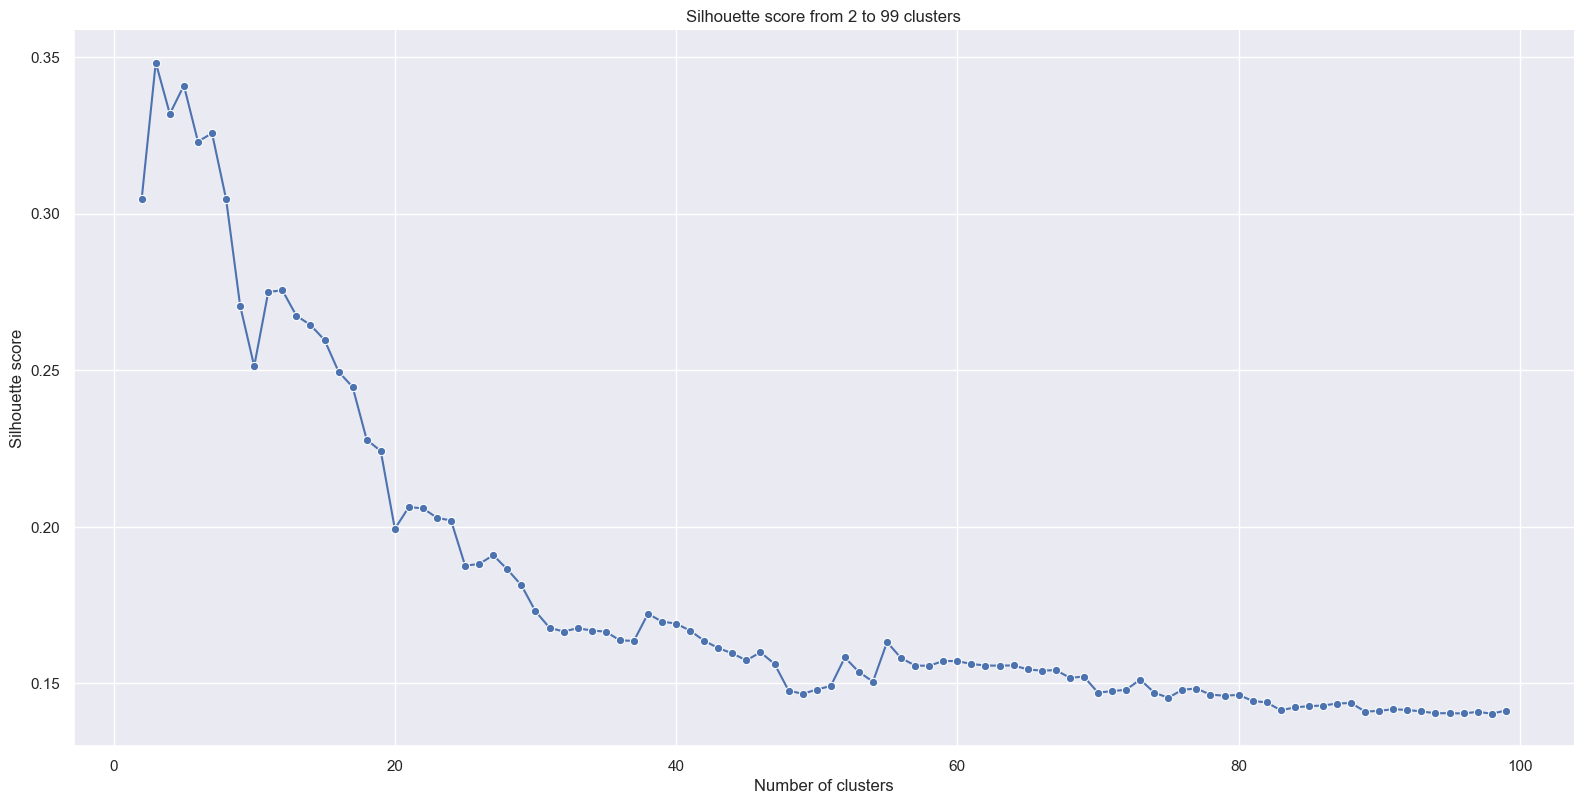

In [51]:
(
sns.relplot(y = sil_scores,
            x = range(2, max_k),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
.set(title=f"Silhouette score from 2 to {max_k - 1} clusters")
.set_axis_labels("Number of clusters", "Silhouette score")
);

In our case, we have been asked to create playlists and we have not been given a hard limit for the number of playlists, but we have been asked to keep the size of all the playlists between 50 and 250 songs. If we have a dataset with 5160 songs, that means that we should explore having between 21 and 103 clusters. Let's look at tese numbers more closely.

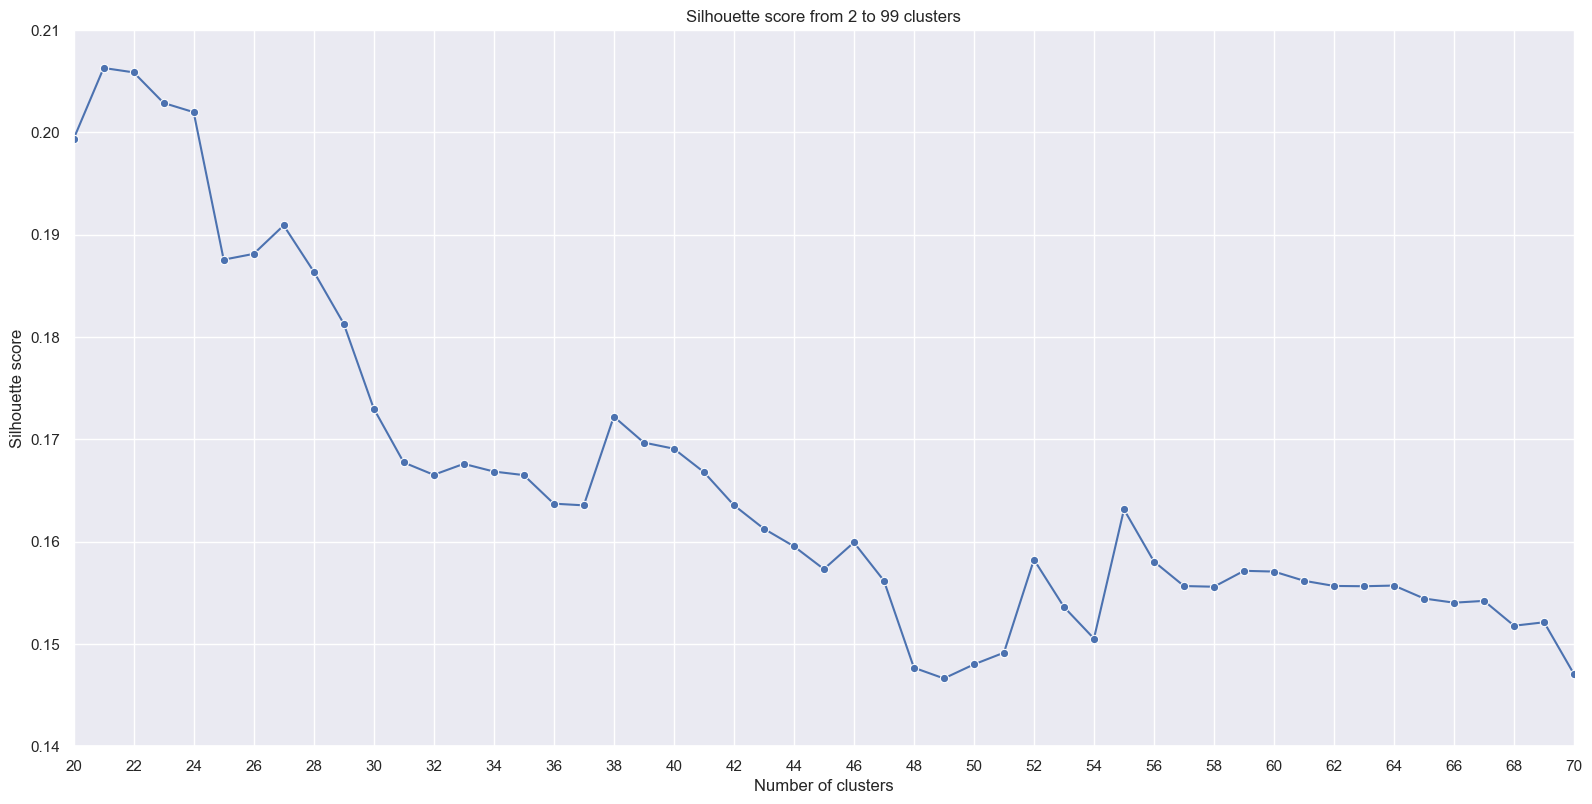

In [52]:

sns.relplot(y = sil_scores,
            x = range(2, max_k),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2
            ).set(
                title=f"Silhouette score from 2 to {max_k - 1} clusters"
                ).set_axis_labels(
                    "Number of clusters", "Silhouette score"
                    )


# Set x-axis limits to show only the range from 20 to 70
plt.xlim(20, 70)

# Set y-axis limits
plt.ylim(0.14, 0.21)

# Set custom x-ticks with an interval of 2
plt.xticks(range(20, 71, 2))  # x-values from 20 to 70 with an interval of 2

# Show the plot
plt.show()

> We see that the optimal number of clusters can be 21, or even 27. In these numbers we have the highest silhouette score. Let's choose the first highest number for now, i.e. 21.

To determine the optimal number of clusters, we can look for the highest silhouette score. This score measures how well each point is assigned to its cluster, with higher scores indicating better clustering.

However, the highest silhouette score may not always be the best choice. For example, if the score is very high for a large number of clusters, it may be a sign that the clusters are too finely grained and that we are overfitting the data.

In addition, we should consider our business objectives and the data we are using. For example, if we are clustering customers based on their purchase history, we may want to choose a smaller number of clusters so that we can easily identify different customer segments.

Therefore, it's important to use the silhouette score in conjunction with other methods, such as the elbow method, and to consider our business objectives and the data we are using when choosing the optimal number of clusters.
> You can also experiment with different values for random_state. It's possible that you got a "bad seed" and this is leading to misleading results. Make sure to use the same random_state for both the inertia and silhouette methods so that you are comparing the same clusters.

---
### 5.&nbsp; Push into algorithm: Using K-means clustering

- **When to Use**: Use K-means when you want to perform clustering on your dataset to group similar data points based on certain features.
- **Purpose**: K-means partitions the dataset into K clusters in which each data point belongs to the cluster of the nearest centroid.
- **Best Practices**:
  - Before using K-means, ensure that your features are scaled.
  - Choose the value of K using methods like the Elbow Method or Silhouette Score to determine the optimal number of clusters.
  - After clustering, analyze the cluster quality and characteristics.

In [53]:
spotify_5000_PCA_k21 = spotify_5000_songs_minmax_scaled.copy()

We will `.fit()` the k-means model to our data.

In [54]:
# initialize the model
my_kmeans21 = KMeans(n_clusters = 21, 
                        random_state = 789)

# fit the model to the data
my_kmeans21.fit(spotify_5000_PCA_k21)

# obtain the cluster output
clusters21 = my_kmeans21.labels_

# attach the cluster output to our original DataFrame
spotify_5000_PCA_k21["clusters"] = clusters21

spotify_5000_PCA_k21.sort_values(by="clusters")

danceability    energy  \
combined_index                                                               
Sr. Chinarro                                   ...      0.615385  0.776995   
Frankie Cosmos                                 ...      0.687018  0.594992   
The Go-Betweens                                ...      0.458894  0.916998   
The Go-Betweens                                ...      0.615385  0.736995   
The Beatles                                    ...      0.513996  0.857997   
...                                                          ...       ...   
The Magnetic Fields                            ...      0.614283  0.846997   
City and Colour                                ...      0.467710  0.626992   
Paula Morelenbaum                              ...      0.699140  0.545991   
Stevie Wonder                                  ...      0.552568  0.446989   
The Drums                                      ...      0.532731  0.717994   

                                                    loudness  mode  \
combined_index                                                       
Sr. Chinarro                                   ...  0.793018   1.0   
Frankie Cosmos                                 ...  0.842682   1.0   
The Go-Betweens                                ...  0.784777   1.0   
The Go-Betweens                                ...  0.728032   1.0   
The Beatles                                    ...  0.784144   1.0   
...                                                      ...   ...   
The Magnetic Fields                            ...  0.827490   1.0   
City and Colour                                ...  0.822659   1.0   
Paula Morelenbaum                              ...  0.720338   1.0   
Stevie Wonder                                  ...  0.721715   1.0   
The Drums                                      ...  0.802439   1.0   

                                                    speechiness  acousticness  \
combined_index                                                                  
Sr. Chinarro                                   ...     0.024937      0.062149   
Frankie Cosmos                                 ...     0.041381      0.028815   
The Go-Betweens                                ...     0.060354      0.005201   
The Go-Betweens                                ...     0.008854      0.036245   
The Beatles                                    ...     0.045175      0.293173   
...                                                         ...           ...   
The Magnetic Fields                            ...     0.039935      0.671687   
City and Colour                                ...     0.009035      0.842369   
Paula Morelenbaum                              ...     0.031442      0.399598   
Stevie Wonder                                  ...     0.057463      0.280120   
The Drums                                      ...     0.013914      0.446787   

                                                    instrumentalness  \
combined_index                                                         
Sr. Chinarro                                   ...          0.198985   
Frankie Cosmos                                 ...          0.000043   
The Go-Betweens                                ...          0.073909   
The Go-Betweens                                ...          0.003310   
The Beatles                                    ...          0.001015   
...                                                              ...   
The Magnetic Fields                            ...          0.062437   
City and Colour                                ...          0.002396   
Paula Morelenbaum                              ...          0.077157   
Stevie Wonder                                  ...          0.000000   
The Drums                                      ...          0.163452   

                                                    liveness   valence  \
combined_index                                               

Now, the 5160 songs dataset is classified to 21 clusters from 0 to 20.

---
### 6.&nbsp; Explore the cluster means 🗺️

In [55]:
spotify_5000_PCA_k21_mean = spotify_5000_PCA_k21.copy()

#### 6.1.&nbsp; Column averages
By grouping the clusters and looking at the average score for each column, you can learn more about the different groups of songs and their mood. 

In [56]:
spotify_5000_PCA_k21_mean.groupby(by="clusters").mean()

danceability    energy  loudness  mode  speechiness  acousticness  \
clusters                                                                      
0             0.665401  0.823094  0.842069   1.0     0.067468      0.089627   
1             0.205832  0.092990  0.440759   1.0     0.038875      0.947421   
2             0.629437  0.728911  0.844417   0.0     0.085297      0.094105   
3             0.246718  0.896570  0.790584   1.0     0.139803      0.012403   
4             0.333206  0.168216  0.603640   1.0     0.040313      0.913186   
5             0.219833  0.905174  0.785200   0.0     0.147651      0.010113   
6             0.205318  0.091433  0.442786   0.0     0.037664      0.946494   
7             0.666814  0.577959  0.783911   0.0     0.141048      0.561717   
8             0.230836  0.935978  0.818007   1.0     0.193206      0.003725   
9             0.746851  0.755854  0.842932   0.0     0.152926      0.113371   
10            0.400037  0.190385  0.561236   1.0     0.045824      0.927588   
11            0.782151  0.624352  0.803214   1.0     0.191810      0.154072   
12            0.327732  0.913503  0.841728   0.0     0.178240      0.019301   
13            0.508478  0.262035  0.671612   0.0     0.054297      0.808713   
14            0.545679  0.396637  0.735684   1.0     0.048865      0.672558   
15            0.382429  0.816533  0.834406   1.0     0.113657      0.064275   
16            0.454411  0.220012  0.570920   0.0     0.046182      0.881673   
17            0.641487  0.786694  0.826482   0.0     0.081422      0.080731   
18            0.605690  0.799500  0.841077   1.0     0.183679      0.140720   
19            0.615415  0.715849  0.838177   1.0     0.067496      0.098923   
20            0.630956  0.637970  0.786311   1.0     0.074610      0.574561   

          instrumentalness  liveness   valence     tempo  duration_ms  
clusters                                                               
0                 0.035916  0.154308  0.802359  0.518997     0.048266  
1                 0.874670  0.114635  0.085495  0.276729     0.100014  
2                 0.014501  0.179438  0.391462  0.488818     0.050527  
3                 0.824453  0.196691  0.241351  0.488728     0.058454  
4                 0.049667  0.175296  0.199732  0.395128     0.061603  
5                 0.812565  0.188552  0.207494  0.486137     0.060689  
6                 0.880520  0.117479  0.069783  0.339386     0.085186  
7                 0.017079  0.189025  0.685551  0.460326     0.052449  
8                 0.141412  0.189182  0.152165  0.453864     0.061519  
9                 0.010555  0.167414  0.774973  0.469268     0.051040  
10                0.863421  0.141766  0.260566  0.564836     0.060067  
11                0.014919  0.122307  0.709437  0.407023     0.049982  
12                0.075744  0.263923  0.211019  0.507595     0.058418  
13                0.038757  0.164897  0.358548  0.451935     0.058049  
14                0.031661  0.163244  0.468362  0.450437     0.053374  
15                0.054116  0.179245  0.456679  0.631141     0.052881  
16                0.871066  0.138720  0.313787  0.433521     0.060628  
17                0.746360  0.202093  0.500648  0.518190     0.065514  
18                0.015637  0.577612  0.566605  0.486044     0.054361  
19                0.021003  0.147493  0.329508  0.453861     0.054462  
20                0.034998  0.180200  0.833246  0.502780     0.041493

#### 6.2.&nbsp; Radar chart
Having calculated the average score for each feature by cluster, we now have a matrix that we can analyse. However, as data scientists with coding skills, we can visualise this information to gain a clearer understanding of why certain song are clustered together and why others aren't.

Visualising the data can help us to identify patterns and trends that would be difficult to see in a matrix. For example, we might be able to see that certain feature are consistently grouped together, while others are more spread out. This could suggest that there are different subgroups of songs with different features.

We can also use visualisation to identify outliers. For example, we might find a few songs who have very different duration than the rest of the group.

In [57]:
# Create an empty list to store the Scatterpolar object of each cluster
scatter_objects = []

# State the label for each arm of the chart
categories = spotify_5000_PCA_k21_mean.columns

# Iterate over the unique clusters and add an object for each cluster to the list
for cluster in sorted(spotify_5000_PCA_k21_mean['clusters'].unique()):

  # Find the mean value for each column of the cluster
  cluster_means = [spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[0]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[1]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[2]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[3]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[4]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[5]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[6]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[7]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[8]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[9]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[10]].mean(),
                  spotify_5000_PCA_k21_mean.loc[spotify_5000_PCA_k21_mean["clusters"] == cluster, spotify_5000_PCA_k21_mean.columns[11]].mean()]
                  # Bonus: see if you can turn this code for `cluster_means` into a list comprehension

  # Create a Scatterpolar object for the cluster
  cluster_scatter = go.Scatterpolar(
    r = cluster_means, # set the radial coordinates
    theta = categories, # the names of the columns
    fill = 'toself', # fills in the space with colour
    name = f'Cluster {cluster}' # adds the name of the cluster
  )

  # Add the Scatterpolar object to the list
  scatter_objects.append(cluster_scatter)

# Create the figure (the white area)
fig = go.Figure()

# Add the scatter objects to the figure
fig.add_traces(scatter_objects)

# Add extras to the plot, such as title
fig.update_layout(
  title_text = 'Radar chart of mean of the features by cluster',
  height = 550,
  width = 800,
  polar = dict(
    radialaxis = dict(
      visible = True, # visibility of the numbers on the arm
      range = [0, 1] # scale of the plot
    )),
  showlegend = True
)

# Show the initialised plot and the trace objects
fig.show()

---
### 7.&nbsp; More exploration

In [60]:
spotify_5000_PCA_k21.sample(2)

danceability    energy  \
combined_index                                                               
Colbie Caillat                                 ...      0.692528  0.476989   
The Crickets                                   ...      0.597752  0.596992   

                                                    loudness  mode  \
combined_index                                                       
Colbie Caillat                                 ...  0.824561   1.0   
The Crickets                                   ...  0.801696   1.0   

                                                    speechiness  acousticness  \
combined_index                                                                  
Colbie Caillat                                 ...     0.024214      0.596386   
The Crickets                                   ...     0.013914      0.716867   

                                                    instrumentalness  \
combined_index                                                         
Colbie Caillat                                 ...               0.0   
The Crickets                                   ...               0.0   

                                                    liveness   valence  \
combined_index                                                           
Colbie Caillat                                 ...  0.106649  0.245908   
The Crickets                                   ...  0.077246  0.876735   

                                                       tempo  duration_ms  \
combined_index                                                              
Colbie Caillat                                 ...  0.519220     0.043211   
The Crickets                                   ...  0.570216     0.023360   

                                                    clusters  
combined_index                                                
Colbie Caillat                                 ...        14  
The Crickets                                   ...        20

In [61]:
df_scaled = spotify_5000_PCA_k21.copy()

In [62]:
pca_variance_df.sample(2)

pca0      pca1  \
combined_index                                                           
Alicia Keys                                    ... -0.314454 -0.601591   
Culcha Candela                                 ... -0.580834 -0.543563   

                                                        pca2      pca3  \
combined_index                                                           
Alicia Keys                                    ...  0.005606 -0.333061   
Culcha Candela                                 ...  0.076776 -0.004069   

                                                        pca4      pca5  \
combined_index                                                           
Alicia Keys                                    ... -0.339752 -0.050398   
Culcha Candela                                 ...  0.035702  0.078169   

                                                        pca6  
combined_index                                                
Alicia Keys                                    ...  0.087377  
Culcha Candela                                 ...  0.160944

In [63]:
df_pca = pca_variance_df.copy()

In [64]:
# Step 3: Fit K-Means for a Chosen Number of Clusters
n_clusters = 21
kmeans_final = KMeans(n_clusters=n_clusters, n_init="auto", random_state=seed)
kmeans_final.fit(df_pca)

# Add the cluster labels to the DataFrame
df_pca['cluster'] = kmeans_final.labels_

# Explore the cluster means
cluster_means = df_pca.groupby('cluster').mean()
cluster_means

pca0      pca1      pca2      pca3      pca4      pca5      pca6
cluster                                                                      
0       -0.409143  0.449859  0.096288  0.151809  0.082059 -0.080093 -0.054567
1       -0.367813 -0.578489 -0.312966 -0.344192  0.041254 -0.025728 -0.069495
2        0.654148  0.239119  0.531814 -0.379169  0.037989  0.021460 -0.036948
3        0.265266  0.293817 -0.756755  0.109118 -0.003445  0.012392 -0.013781
4        0.963956 -0.866485  0.111495  0.085492 -0.021339 -0.000203 -0.002859
5        1.247478  0.097108  0.088221  0.025661 -0.105185  0.048900 -0.042496
6        0.119948 -0.676209  0.535789 -0.148030  0.065090  0.001264 -0.026848
7       -0.127472  0.392359 -0.393540 -0.324837  0.021346  0.002691 -0.073270
8        0.039820 -0.679655 -0.712072  0.106462  0.022647  0.001164 -0.037724
9       -0.523904 -0.551480 -0.014874 -0.088307  0.202160  0.310202  0.161779
10      -0.187208  0.398383 -0.019942 -0.185824 -0.095785 -0.079920  0.073714
11      -0.562906 -0.543496  0.254084  0.157467 -0.031374 -0.013202 -0.042759
12       0.246210  0.317209  0.459285 -0.129572  0.018479 -0.027058 -0.006928
13      -0.010636  0.371217  0.367697 -0.023337  0.253366  0.377306  0.077358
14      -0.310648  0.421880  0.257056  0.142466 -0.150020 -0.001227  0.010515
15       1.043779  0.135272  0.146806  0.210804  0.084917 -0.079275  0.142402
16      -0.051343  0.380982  0.488478  0.172417  0.138631 -0.000346 -0.103124
17       0.083078  0.328738 -0.413257  0.401691  0.017054  0.000914  0.062126
18      -0.358806  0.433748 -0.012278 -0.044780  0.067368  0.216253  0.129716
19      -0.447020 -0.569099  0.038839 -0.132718 -0.065865 -0.065069  0.054935
20      -0.097071 -0.659067 -0.285972  0.434662 -0.041155 -0.001562  0.096481

In [65]:
# Step 4: Radar Chart for Cluster Means
# Create an empty list to store Scatterpolar objects for each cluster
scatter_objects = []

# State the labels for each axis (features)
categories = df_pca.columns[:-1]  # Exclude 'cluster' column

# Iterate over each cluster and create a Scatterpolar plot
for cluster in sorted(df_pca['cluster'].unique()):
    cluster_means = df_pca[df_pca['cluster'] == cluster][categories].mean().tolist()

    # Add the first value to the end to close the radar chart loop
    cluster_means.append(cluster_means[0])

    # Create Scatterpolar object
    scatter = go.Scatterpolar(
        r=cluster_means,
        theta=categories.tolist() + [categories[0]],
        fill='toself',
        name=f'Cluster {cluster}'
    )

    scatter_objects.append(scatter)

# Create the radar chart figure
fig = go.Figure(data=scatter_objects)

# Add layout details
fig.update_layout(
    title="Radar Chart of Cluster Means",
    height=600,
    width=800,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[df_pca[categories].min().min(), df_pca[categories].max().max()]
        )
    ),
    showlegend=True
)

# Show the radar chart
fig.show()


In [66]:
df_pca.head(3)

pca0      pca1  \
combined_index                                                           
Gilberto Gil                                   ...  0.096136 -0.679796   
Antônio Carlos Jobim                           ... -0.135237  0.388148   
Martinho Da Vila                               ... -0.281878  0.414121   

                                                        pca2      pca3  \
combined_index                                                           
Gilberto Gil                                   ...  0.516554 -0.292388   
Antônio Carlos Jobim                           ...  0.396328  0.100987   
Martinho Da Vila                               ...  0.467163  0.277768   

                                                        pca4      pca5  \
combined_index                                                           
Gilberto Gil                                   ...  0.247788  0.637553   
Antônio Carlos Jobim                           ... -0.115936 -0.135223   
Martinho Da Vila                               ... -0.095818  0.127416   

                                                        pca6  cluster  
combined_index                                                         
Gilberto Gil                                   ...  0.426917        6  
Antônio Carlos Jobim                           ...  0.077549       14  
Martinho Da Vila                               ...  0.000084       14

In [70]:
# Set the number of items to display per cluster
max_items_per_cluster = 5

# Create a dictionary where each key is a cluster, and the value is a list of index values in that cluster
cluster_dict = {}
for cluster in sorted(df_pca['cluster'].unique()):
    cluster_items = df_pca[df_pca['cluster'] == cluster].index.tolist()
    # Limit to the specified number of items per cluster
    cluster_dict[f'Cluster {cluster}'] = cluster_items[:max_items_per_cluster]

# Convert the dictionary to a DataFrame
df_cluster_summary = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster_dict.items()]))

In [71]:
df_cluster_summary.T

0  \
Cluster 0   Batida                                        ...   
Cluster 1   The Libertines                                ...   
Cluster 2   Kurt Elling                                   ...   
Cluster 3   Los Planetas                                  ...   
Cluster 4   Carlos Barbosa-Lima                           ...   
Cluster 5   Raphael Rabello                               ...   
Cluster 6   Gilberto Gil                                  ...   
Cluster 7   Modern English                                ...   
Cluster 8   Ben Howard                                    ...   
Cluster 9   Chico César                                   ...   
Cluster 10  Marcos Valle                                  ...   
Cluster 11  Marcos Valle                                  ...   
Cluster 12  Chico César                                   ...   
Cluster 13  Sílvia Pérez Cruz                             ...   
Cluster 14  Antônio Carlos Jobim                          ...   
Cluster 15  Brazilian Jazz                                ...   
Cluster 16  Paula Morelenbaum                             ...   
Cluster 17  Marcos Valle                                  ...   
Cluster 18  Gilberto Gil                                  ...   
Cluster 19  Brazilian Jazz                                ...   
Cluster 20  Joe Henderson                                 ...   

                                                            1  \
Cluster 0   Batida                                        ...   
Cluster 1   Girls                                         ...   
Cluster 2   Stan Getz                                     ...   
Cluster 3   Clem Snide                                    ...   
Cluster 4   Cannonball Adderley                           ...   
Cluster 5   Sigur Rós                                     ...   
Cluster 6   Maria Gasolina                                ...   
Cluster 7   Warm Soda                                     ...   
Cluster 8   The Mountain Goats                            ...   
Cluster 9   Gilberto Gil                                  ...   
Cluster 10  Asaf Avidan                                   ...   
Cluster 11  Rio Combo                                     ...   
Cluster 12  Stan Getz                                     ...   
Cluster 13  Sonny Rollins                                 ...   
Cluster 14  Martinho Da Vila                              ...   
Cluster 15  Voyager                                       ...   
Cluster 16  Bossacucanova                                 ...   
Cluster 17  Barbatuques                                   ...   
Cluster 18  The Doors                                     ...   
Cluster 19  Mundo Livre                                   ...   
Cluster 20  Marcos Valle                                  ...   

                                                            2  \
Cluster 0   L.A.                                          ...   
Cluster 1   M.I.A.                                        ...   
Cluster 2   Chico César                                   ...   
Cluster 3   Big Surr                                      ...   
Cluster 4   Brazilian Jazz                                ...   
Cluster 5   Nico Roig                                     ...   
Cluster 6   Sílvia Pérez Cruz                             ...   
Cluster 7   The Magnetic Fields                           ...   
Cluster 8   Súper Gegant                                  ...   
Cluster 9   Jorge Ben Jor                                 ...   
Cluster 10  Guided By Voices                              ...   
Cluster 11  Bïa                                           ...   
Cluster 12  Antônio Carlos Jobim                          ...   
Cluster 13  Gal Costa                                     ...   
Cluster 14  Mundo Livre S/A                               ...   
Cluster 15  Cannonball Adderley                           ...   
Cluster 16  Marcos Valle                                  ...   
Cluster 17  Batida          

In [74]:
df_pca.sample(2)

pca0      pca1  \
combined_index                                                           
Monsta X                                       ... -0.664785 -0.528495   
Tokio Hotel                                    ... -0.619761 -0.525349   

                                                        pca2      pca3  \
combined_index                                                           
Monsta X                                       ...  0.036066  0.022343   
Tokio Hotel                                    ... -0.135870 -0.106663   

                                                        pca4      pca5  \
combined_index                                                           
Monsta X                                       ... -0.169168  0.052899   
Tokio Hotel                                    ...  0.150942  0.090795   

                                                        pca6  cluster  
combined_index                                                         
Monsta X                                       ...  0.001996       19  
Tokio Hotel                                    ... -0.053993        9

In [75]:
df_scaled.sample(2)

danceability    energy  \
combined_index                                                               
Dead Prez                                      ...      0.576813  0.542991   
Revolverheld                                   ...      0.351995  0.867997   

                                                    loudness  mode  \
combined_index                                                       
Dead Prez                                      ...  0.658105   1.0   
Revolverheld                                   ...  0.891624   1.0   

                                                    speechiness  acousticness  \
combined_index                                                                  
Dead Prez                                      ...     0.687387      0.000645   
Revolverheld                                   ...     0.041200      0.010141   

                                                    instrumentalness  \
combined_index                                                         
Dead Prez                                      ...           0.00334   
Revolverheld                                   ...           0.00000   

                                                    liveness   valence  \
combined_index                                                           
Dead Prez                                      ...  0.102551  0.178579   
Revolverheld                                   ...  0.093331  0.263518   

                                                       tempo  duration_ms  \
combined_index                                                              
Dead Prez                                      ...  0.242081     0.047954   
Revolverheld                                   ...  0.765433     0.048677   

                                                    clusters  
combined_index                                                
Dead Prez                                      ...        19  
Revolverheld                                   ...        15

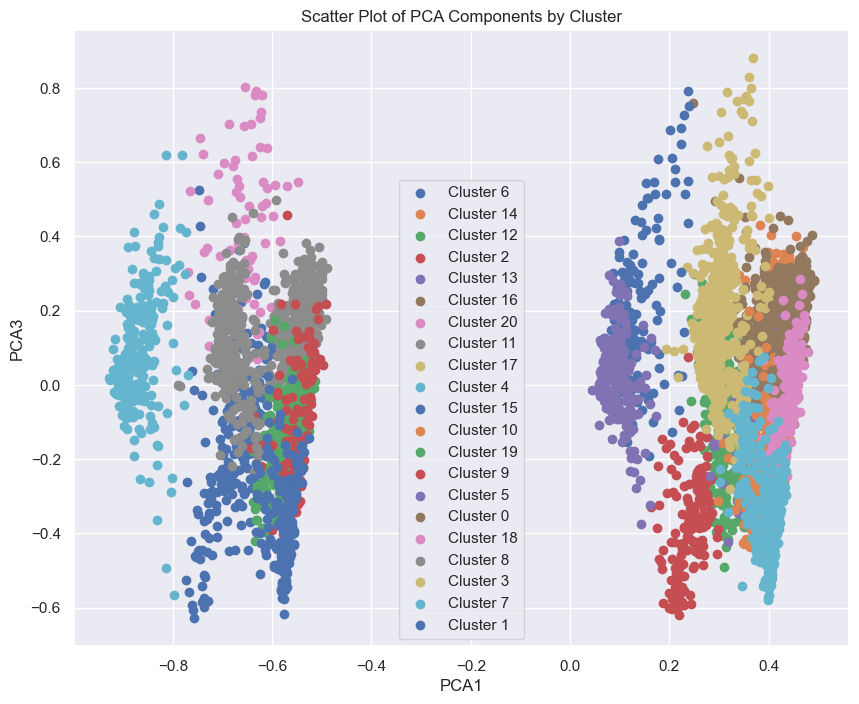

In [78]:
# prompt: use df_pca, make scatter plot, x axes - pca1, y axes - pca2, cluster - different colors

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for cluster in df_pca['cluster'].unique():
    plt.scatter(df_pca.loc[df_pca['cluster'] == cluster, 'pca1'],
                df_pca.loc[df_pca['cluster'] == cluster, 'pca3'],
                label=f'Cluster {cluster}')
plt.xlabel('PCA1')
plt.ylabel('PCA3')
plt.title('Scatter Plot of PCA Components by Cluster')
plt.legend()
plt.show()

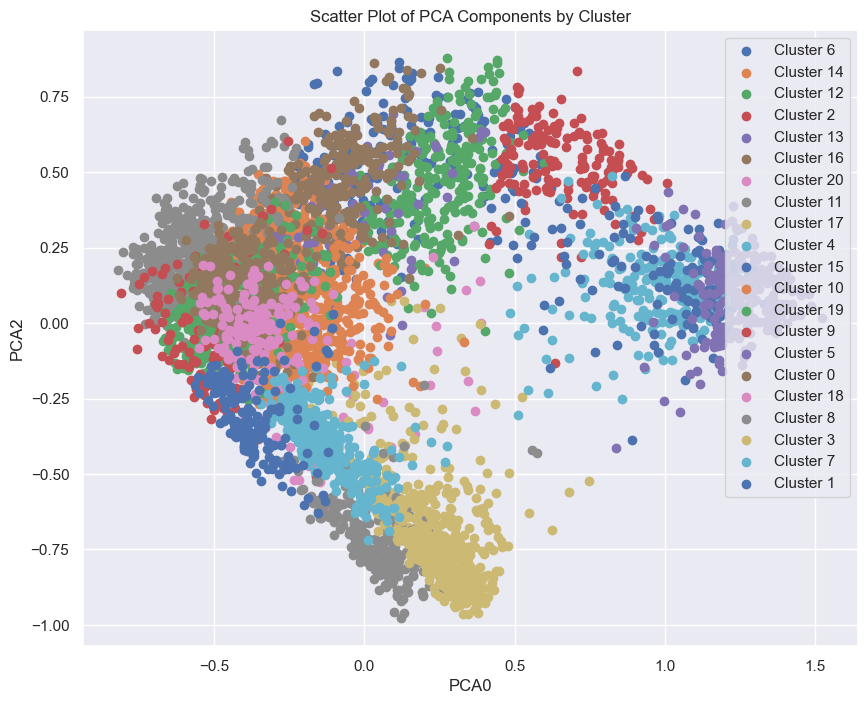

In [77]:
# prompt: use df_pca, make scatter plot, x axes - pca1, y axes - pca2, cluster - different colors

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for cluster in df_pca['cluster'].unique():
    plt.scatter(df_pca.loc[df_pca['cluster'] == cluster, 'pca0'],
                df_pca.loc[df_pca['cluster'] == cluster, 'pca2'],
                label=f'Cluster {cluster}')
plt.xlabel('PCA0')
plt.ylabel('PCA2')
plt.title('Scatter Plot of PCA Components by Cluster')
plt.legend()
plt.show()

In [82]:
# You can change PCA feature

fig = px.scatter(df_pca, x='pca1', y='pca3', color='cluster', hover_name=df_pca.index)
fig.show()

In [84]:
df_pca2 = df_pca.copy()
df_pca2['cluster'] = df_pca2['cluster'].astype(str)
custom_colors = {
    '0': 'gray',
    '1': '#4682B4',
    '2': '#FFD700',
    '3': '#2F4F4F',
    '4': '#4682B4',
    '5': 'gray',
    '6': '#2F4F4F',
    '7': '#800080',
    '8': 'gray',
    '9': '#39FF14',
    '10': '#2F4F4F',
    '11': '#2F4F4F',
    '12': 'gray',
    '13': '#800080',
    '14': '#FFA500',
    '15': '#FFA500',
    '16': 'gray',
    '17': 'gray',
    '18': 'gray',
    '19': 'gray',
    '20': '#FFD700',
    '21': 'gray'
}
# 2,20 pop, hip hop
# 15,14 oldies, classic rock, pop
# 7,13 jazz, romantic, oldies
# 4,1 classical, instrumental
# 9 electronic
# 0 rock
# 3,6,10,11 death metal

fig = px.scatter(df_pca2, x='pca1', y='pca3', color='cluster', hover_name=df_pca2.index, color_discrete_map=custom_colors)
fig.show()

  # Apply custom colors